In [32]:
# IMPORT LIBRARIES
import os, shutil, random, itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [33]:
# CONFIG
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (khuyến nghị nếu GPU hỗ trợ)
try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
except Exception:
    pass
DST_DIR = Path("dataset")
IMG_SIZE = 224
BATCH_SIZE = 32

In [34]:
# Colab: làm việc ở /content
import os, pathlib, sys, shutil, subprocess
from pathlib import Path

REPO_URL = "https://github.com/mlinh1711/waste_classification.git"
REPO_DIR = Path("/content/waste_classification")   # tên thư mục sau khi clone

# Clone (nếu chưa có)
if not REPO_DIR.exists():
    !git clone {REPO_URL} {REPO_DIR}

# Chọn thư mục dataset bạn dùng trong notebook:
SRC_DIR = REPO_DIR / "Waste_Classification_Dataset"

print("Repo dir:", REPO_DIR)
print("SRC_DIR :", SRC_DIR, "(exists:", SRC_DIR.exists(), ")")


Repo dir: /content/waste_classification
SRC_DIR : /content/waste_classification/Waste_Classification_Dataset (exists: True )


In [35]:
# DATASET SUMMARY
class_names, class_counts = [], []
for cls in sorted([p.name for p in SRC_DIR.iterdir() if p.is_dir()]):
    n = len([f for f in (SRC_DIR/cls).iterdir() if f.is_file()])
    class_names.append(cls)
    class_counts.append(n)
    print(f"There are {n} {cls} images.")


There are 2283 Metal images.
There are 4424 Miscellaneous images.
There are 2767 Paper images.
There are 6807 Plastic images.


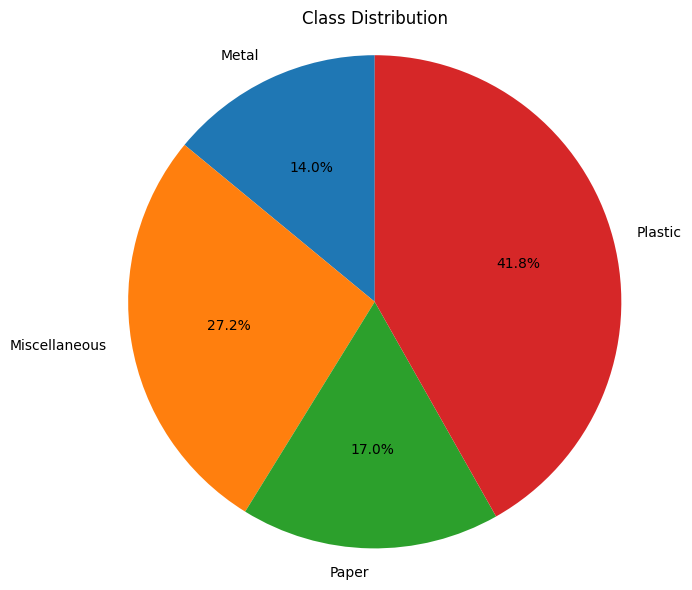

In [36]:
# CLASS DISTRIBUTION
plt.figure(figsize=(7,7))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.axis("equal"); plt.show()

In [37]:
ext_counter = Counter()
sizes_kb = []
dims = []

valid_dirs = [p for p in SRC_DIR.iterdir() if p.is_dir()]
for d in valid_dirs:
    for f in d.iterdir():
        if not f.is_file(): continue
        ext_counter[f.suffix.lower()] += 1
        try:
            sizes_kb.append(f.stat().st_size/1024)
            with Image.open(f) as im:
                dims.append(im.size)  # (W,H)
        except Exception:
            pass

print("File extensions distribution:", ext_counter)
print(f"Min size: {np.min(sizes_kb):.2f} KB | Max: {np.max(sizes_kb):.2f} KB | Avg: {np.mean(sizes_kb):.2f} KB")


File extensions distribution: Counter({'.jpg': 16281})
Min size: 8.50 KB | Max: 106.35 KB | Avg: 30.09 KB


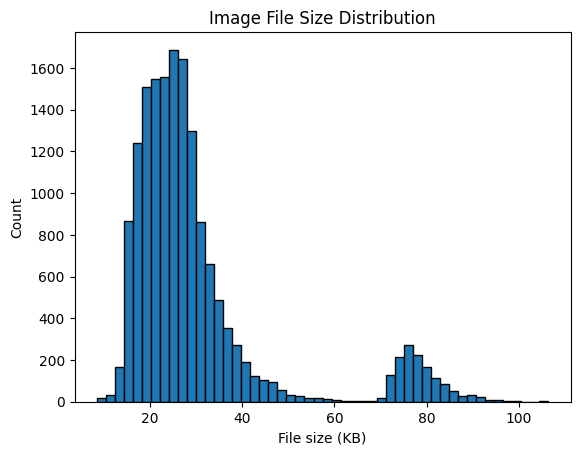

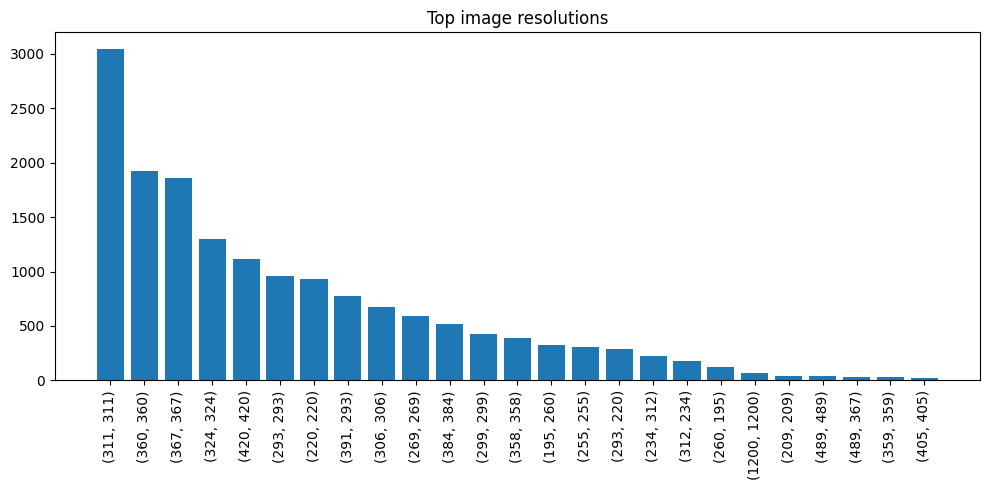

In [38]:
plt.hist(sizes_kb, bins=50, edgecolor='black')
plt.xlabel("File size (KB)"); plt.ylabel("Count"); plt.title("Image File Size Distribution"); plt.show()

dim_counter = Counter(dims)
df_dims = (pd.DataFrame(dim_counter.items(), columns=["Resolution (W,H)","Count"])
           .sort_values("Count", ascending=False).head(25).reset_index(drop=True))
plt.figure(figsize=(10,5))
plt.bar(df_dims["Resolution (W,H)"].astype(str), df_dims["Count"])
plt.xticks(rotation=90); plt.title("Top image resolutions"); plt.tight_layout(); plt.show()

In [39]:
# SPLIT DATASET
def split_3ways(src_dir: Path, dst_dir: Path, train=0.8, val=0.1, test=0.1, seed=SEED):
    assert abs(train+val+test-1.0) < 1e-6
    if dst_dir.exists():
        print(f"Xoá thư mục đích {dst_dir} để tạo mới...")
        shutil.rmtree(dst_dir)
    for sp in ["train","val","test"]:
        (dst_dir/sp).mkdir(parents=True, exist_ok=True)

    rng = random.Random(seed)
    valid_exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

    for cls_dir in sorted([p for p in src_dir.iterdir() if p.is_dir()]):
        cls = cls_dir.name
        imgs = [p for p in cls_dir.rglob("*") if p.suffix.lower() in valid_exts]
        rng.shuffle(imgs)

        n = len(imgs)
        n_train = int(n*train)
        n_val   = int(n*val)
        n_test  = n - n_train - n_val

        splits = {
            "train": imgs[:n_train],
            "val"  : imgs[n_train:n_train+n_val],
            "test" : imgs[n_train+n_val:]
        }

        for sp, files in splits.items():
            out_cls = dst_dir/sp/cls
            out_cls.mkdir(parents=True, exist_ok=True)
            for src in files:
                shutil.copy2(src, out_cls/src.name)

        print(f"Class '{cls}': {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")

split_3ways(SRC_DIR, DST_DIR, train=0.8, val=0.1, test=0.1)
print("Done.")


Xoá thư mục đích dataset để tạo mới...
Class 'Metal': 1826 train, 228 val, 229 test
Class 'Miscellaneous': 3539 train, 442 val, 443 test
Class 'Paper': 2213 train, 276 val, 278 test
Class 'Plastic': 5445 train, 680 val, 682 test
Done.


In [40]:
# Sanity check số lượng ảnh trong train/val/test
def count_images(path: Path):
    tot = 0
    for cls in [p for p in path.iterdir() if p.is_dir()]:
        n = len([f for f in cls.iterdir() if f.is_file()])
        print(f"{path.name}/{cls.name}: {n}")
        tot += n
    print(f"==> Total in {path.name}: {tot}\n")
    return tot

train_total = count_images(DST_DIR/"train")
val_total   = count_images(DST_DIR/"val")
test_total  = count_images(DST_DIR/"test")
assert train_total>0 and val_total>0 and test_total>0


train/Paper: 2213
train/Miscellaneous: 3539
train/Plastic: 5445
train/Metal: 1826
==> Total in train: 13023

val/Paper: 276
val/Miscellaneous: 442
val/Plastic: 680
val/Metal: 228
==> Total in val: 1626

test/Paper: 278
test/Miscellaneous: 443
test/Plastic: 682
test/Metal: 229
==> Total in test: 1632



In [41]:
# Cell 5: Keras generators + augmentation
SAFE_AUG = dict(
    rescale=1./255,
    rotation_range=20,                # tăng nhẹ để tăng đa dạng góc
    width_shift_range=0.10,           # tăng chút giúp model học vị trí tốt hơn
    height_shift_range=0.12,
    shear_range=8,                   # tăng nhẹ để tạo méo hình tự nhiên
    zoom_range=0.12,                  # phóng to/thu nhỏ thêm 15%
    horizontal_flip=True,             # vẫn giữ flip ngang
    brightness_range=[0.85, 1.15],    # tăng dải sáng để mô phỏng ánh sáng thật
    channel_shift_range=15.0,         # thay đổi kênh màu nhẹ
    fill_mode='reflect'               # tự nhiên hơn 'nearest' (giảm artifact viền)
)


train_datagen = ImageDataGenerator(**SAFE_AUG)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    str(DST_DIR/"train"), target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED
)
val_gen = test_datagen.flow_from_directory(
    str(DST_DIR/"val"), target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    str(DST_DIR/"test"), target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 13023 images belonging to 4 classes.
Found 1626 images belonging to 4 classes.
Found 1632 images belonging to 4 classes.
Classes: ['Metal', 'Miscellaneous', 'Paper', 'Plastic']


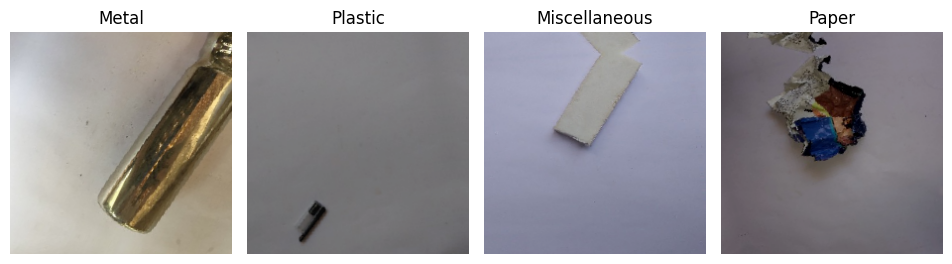

In [42]:
# Hiển thị 1 ảnh đại diện cho mỗi lớp trong batch đầu tiên
import matplotlib.pyplot as plt
import numpy as np

# Lấy 1 batch ảnh từ generator
images, labels = next(iter(train_gen))   # train_gen là generator của bạn
labels_idx = np.argmax(labels, axis=1)   # vì one-hot → lấy index lớn nhất
classes = list(train_gen.class_indices.keys())

shown_classes = set()
plt.figure(figsize=(12, 6))
count = 0

for img, label_idx in zip(images, labels_idx):
    class_name = classes[label_idx]

    if class_name not in shown_classes:
        shown_classes.add(class_name)
        plt.subplot(2, 5, count + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        count += 1

    if count == len(classes):
        break

plt.tight_layout()
plt.show()


## **MODEL**

In [43]:
# Build SimpleCNN (Keras)
def conv_block(x, c, k=3, s=1, p='same'):
    x = layers.Conv2D(c, k, strides=s, padding=p, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

inp = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = conv_block(inp, 32)
x = conv_block(x, 32, s=2)   # l1
x = conv_block(x, 64)
x = conv_block(x, 64, s=2)   # l2
x = conv_block(x, 128)
x = conv_block(x, 128, s=2)  # l3
x = conv_block(x, 256)       # extra
x = layers.Dropout(0.25)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)              # 128 -> 256
x = layers.BatchNormalization()(x)     # thêm BN
x = layers.ReLU()(x)
x = layers.Dropout(0.35)(x)            # 0.30 -> 0.35
out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = models.Model(inp, out)

In [44]:
EPOCHS = 30

# Dùng len(generator) để tránh hụt batch cuối
decay_steps = len(train_gen) * EPOCHS

initial_lr = 3e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=0.10    # LR floor = 10% initial_lr, không rơi về 0
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ],
)

CKPT_DIR = Path("artifacts"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = str(CKPT_DIR / "baseline_best.keras")   # định dạng mới

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_PATH, monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=7, restore_best_weights=True
    ),
]

In [45]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5292 - loss: 1.1621 - precision: 0.5845 - recall: 0.4122
Epoch 1: val_accuracy improved from -inf to 0.45080, saving model to artifacts/baseline_best.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 206s 471ms/step - accuracy: 0.5293 - loss: 1.1619 - precision: 0.5846 - recall: 0.4123 - val_accuracy: 0.4508 - val_loss: 1.3682 - val_precision: 0.4811 - val_recall: 0.3518
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6558 - loss: 0.9156 - precision: 0.7304 - recall: 0.5523
Epoch 2: val_accuracy improved from 0.45080 to 0.59656, saving model to artifacts/baseline_best.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 182s 447ms/step - accuracy: 0.6559 - loss: 0.9155 - precision: 0.7304 - recall: 0.5523 - val_accuracy: 0.5966 - val_loss: 1.0148 - val_precision: 0.6931 - val_recall: 0.5166
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7007 - loss: 0.8339 - precision: 0.7687 - recall: 0.6116
Epoch 3: val_accur

Evaluate on test:
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9009 - loss: 0.4456 - precision: 0.9241 - recall: 0.8818
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step

F1-macro: 0.8885774006507784

Classification report:
               precision    recall  f1-score   support

        Metal     0.7881    0.9258    0.8514       229
Miscellaneous     0.8916    0.9097    0.9006       443
        Paper     0.8869    0.8741    0.8804       278
      Plastic     0.9545    0.8915    0.9219       682

     accuracy                         0.8983      1632
    macro avg     0.8803    0.9003    0.8886      1632
 weighted avg     0.9025    0.8983    0.8992      1632


Confusion matrix:
 [[212  11   1   5]
 [ 17 403  13  10]
 [  9  12 243  14]
 [ 31  26  17 608]]


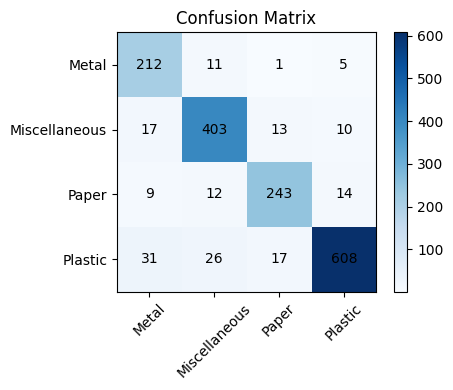

In [46]:
# Evaluate on test & full report
best_model = tf.keras.models.load_model(CKPT_PATH)

print("Evaluate on test:")
best_model.evaluate(test_gen, verbose=1)

y_prob = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

print("\nF1-macro:", f1_score(y_true, y_pred, average='macro'))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# (tuỳ chọn) visualize confusion matrix đẹp
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix"); plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()
